### Setup the imports

In [553]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import math
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline

### Read in the data

In [554]:
train = pd.read_csv('./data/train.csv',  index_col=0)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Fill NA

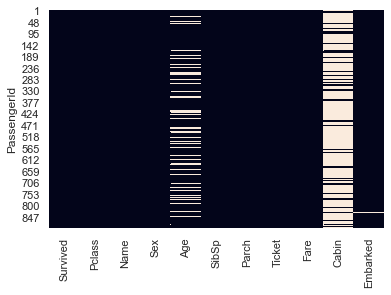

In [555]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(train.isna(), cbar=False)

In [556]:
# REPLACE NA values with age of non- and survived passengers and ...
mean_Age = train.groupby(['Survived','Sex','Pclass'])['Age'].transform('mean')
train['Age'].fillna(mean_Age, inplace=True)

In [526]:
from sklearn.preprocessing import KBinsDiscretizer
# transform a numerical column: Age
kbins = KBinsDiscretizer(n_bins=8, encode='onehot-dense', strategy='kmeans')
columns = train[['Age']]
kbins.fit(columns)
t = kbins.transform(columns)

In [527]:
# fill NA of Embarked with most frequent values, then binning 
pipeline1 = make_pipeline(
            SimpleImputer(strategy='most_frequent'), 
            OneHotEncoder(sparse=False, handle_unknown='ignore')
            )

In [528]:
# fill NA of Embarked with most frequent values, then binning 
pipeline2 = make_pipeline(
            SimpleImputer(strategy='mean'), 
            KBinsDiscretizer(n_bins=8, encode='onehot-dense', strategy='kmeans')
            )

In [529]:
pipeline3 = make_pipeline(
            SimpleImputer(strategy='mean'), 
            MinMaxScaler()
            )

In [557]:
# model 1
trans = ColumnTransformer([
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Sex','Pclass']),
        ('impute_then_onehot',pipeline1, ['Embarked']), 
        ('impute_then_scale', pipeline2, ['Age']),
        ('scale', pipeline3, ['Fare']),
        ('do_nothing', 'passthrough', ['SibSp','Parch']),
        ])

In [558]:
#### Train-Test-Split
from sklearn.model_selection import train_test_split as tts

X = train.iloc[:, 1:]
y = train['Survived']
Xtrain, Xtest,ytrain,ytest = tts(X,y,train_size=0.9)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((801, 10), (90, 10), (801,), (90,))

### Feature Engineering

In [559]:
# fit and transform training data
trans.fit(train)

X = trans.transform(train)
y = train['Survived']

### Train an ML Model

In [560]:
m_lr = LogisticRegression(max_iter=1000)
m_lr.fit(X,y) #(x_train, y_train)

LogisticRegression(max_iter=1000)

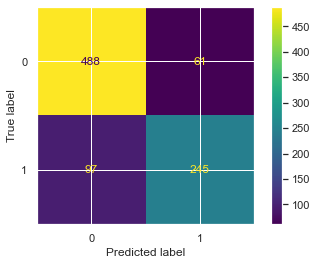

In [561]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(m_lr,X,y)

In [562]:
#Evaluating metrics
from sklearn.metrics import classification_report

ypred = m_lr.predict(X)
# predict
acc = accuracy_score(y,ypred)
print('Train accuracy is:', round(acc,3))

Train accuracy is: 0.823


In [563]:
print(classification_report(y,ypred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       549
           1       0.80      0.72      0.76       342

    accuracy                           0.82       891
   macro avg       0.82      0.80      0.81       891
weighted avg       0.82      0.82      0.82       891



In [537]:
trans.fit(Xtest)
test1 = trans.transform(Xtest)
ypred_test = m_lr.predict(test1)

In [538]:
#calculate probabilities
# prob = m.predict_proba(test1)

In [539]:
acc_test = accuracy_score(ytest, ypred_test)
print('Test accuracy is:', round(acc_test,3))

Test accuracy is: 0.767


In [540]:
# ytrue1 = ytest['Survived']
# draw ROC curve

In [541]:
# from sklearn.metrics import roc_curve

# works for Titanic but not for Penguins
# probs = m.predict_proba(Xtest)
# roc_curve(ytest, probs) #y_true, y_score

### Train a classification tree

In [564]:
# Cross-Validate Decision Tree
from sklearn.tree import DecisionTreeClassifier
m_dt = DecisionTreeClassifier(max_depth=2)  # we allow that many questions
m_dt.fit(X, y)

# Import cross_validate
from sklearn.model_selection import cross_validate
cross_validate_dt = cross_validate(estimator=m_dt, 
                                   X=X, # Xtrain
                                   y=y, # ytrain
                                   scoring='accuracy',                                 
                                   return_train_score=True)

cross_validate_dt['test_score'].mean(), cross_validate_dt['train_score'].mean()

(0.775563367020275, 0.7918082323463134)

In [565]:
# find the appropriate depth
x_a = []
test_score_l = []
train_score_l = []

for i in range(1,15):
    m_dt = DecisionTreeClassifier(max_depth=i)
    # Cross-Validate Decision Tree
    cross_validate_dt = cross_validate(estimator=m_dt, 
                                   X=X, 
                                   y=y, 
                                   scoring='accuracy', 
                                   cv=5, 
                                   return_train_score=True)
    x_a = i
    test_score_l = cross_validate_dt['test_score'].mean()
    train_score_l = cross_validate_dt['train_score'].mean()
    print(x_a,round(test_score_l,3),round(train_score_l,3) )

1 0.787 0.787
2 0.776 0.792
3 0.816 0.835
4 0.834 0.847
5 0.841 0.869
6 0.832 0.889
7 0.831 0.9
8 0.836 0.912
9 0.826 0.925
10 0.824 0.934
11 0.814 0.942
12 0.816 0.948
13 0.805 0.953
14 0.801 0.954


In [544]:
# plot

In [566]:
m_dt = DecisionTreeClassifier(max_depth=5)  # we allow that many questions
m_dt.fit(X, y)

DecisionTreeClassifier(max_depth=5)

### train a random forest model

In [546]:
from sklearn.ensemble import  RandomForestClassifier 

# ? m=RandomForestRegressor(n_estimators=100) 
m_rf = RandomForestClassifier(n_estimators=100)
m_rf.fit (X, y)

RandomForestClassifier()

### compare the models - training score

In [569]:
from sklearn.model_selection import cross_val_score 

def test_classifier(clf):     
   scores = cross_val_score(clf,X,y, cv=5)     
   print('                      %0.3f(+/-%0.3f)'%(scores.mean(),scores.std())) 
   

print('Train accuracy of LR is:')
test_classifier(m_lr)
print('Train accuracy of DT is:')
test_classifier(m_dt)
print('Train accuracy of RF is:')
test_classifier(m_rf)    

Train accuracy of LR is:
                      0.805(+/-0.016)
Train accuracy of DT is:
                      0.841(+/-0.012)
Train accuracy of RF is:
                      0.814(+/-0.013)


### compare the models - test score

In [570]:
#lord test data
#Transform the test data
trans.fit(Xtest)
Xtest1 = trans.transform(Xtest)

In [571]:
m_dt.score(Xtest1, ytest)

0.7444444444444445

In [572]:
# Inspect the accuracy score
print('Test accuracy of LR is:', m_lr.score(Xtest1, ytest))
print('Test accuracy of DT is:', m_dt.score(Xtest1, ytest))
print('Test accuracy of RF is:', m_rf.score(Xtest1, ytest))

Test accuracy of LR is: 0.8
Test accuracy of DT is: 0.7444444444444445
Test accuracy of RF is: 0.8222222222222222


In [551]:
m_lr,m_dt,m_rf
#roc curve

(LogisticRegression(max_iter=1000),
 DecisionTreeClassifier(max_depth=5),
 RandomForestClassifier())

# kragge scoring

In [552]:

test_tia = pd.read_csv('./data/test.csv',  index_col=0)
test_tia.head(200)

trans.fit(test_tia)
test2 = trans.transform(test_tia)

ypred2 = m_lr.predict(test2)
submission = pd.DataFrame(ypred2, index=test_tia.index, columns=['Survived'])
submission.to_csv('submission_lr.csv') # added Embarked -> 0.765, # 0.756(drop Embarked)

ypred3 = m_dt.predict(test2)
submission = pd.DataFrame(ypred3, index=test_tia.index, columns=['Survived'])
submission.to_csv('submission_dt.csv') # added Embarked -> 0.7655, # 0.772(drop Embarked)

ypred4 = m_rf.predict(test2)
submission = pd.DataFrame(ypred4, index=test_tia.index, columns=['Survived'])
submission.to_csv('submission_rf.csv') # added Embarked ->  0.763, # 0.751(drop Embarked)

### 

In [22]:
# Cabin data
# Cabin data
#isolating the rooms and letters
train['Cabin_nr'] = train['Cabin'].fillna('Z',inplace=False) 
train["Deck"] = train["Cabin_nr"].str.slice(0,1)


def one_hot_column(df, label, drop_col=False):
    one_hot = pd.get_dummies(df[label], prefix=label)
    if drop_col:
        df = df.drop(label, axis=1)
    df = df.join(one_hot)
    return df

def one_hot(df, labels, drop_col=False):
    for label in labels:
        df = one_hot_column(df, label, drop_col)
    return df

train = one_hot(train, ["Deck"],drop_col=True)

In [23]:
test['Cabin_nr'] = test['Cabin'].fillna('Z',inplace=False) 
test["Deck"] = test["Cabin_nr"].str.slice(0,1)


def one_hot_column(df, label, drop_col=False):
    one_hot = pd.get_dummies(df[label], prefix=label)
    if drop_col:
        df = df.drop(label, axis=1)
    df = df.join(one_hot)
    return df

def one_hot(df, labels, drop_col=False):
    for label in labels:
        df = one_hot_column(df, label, drop_col)
    return df

test = one_hot(test, ["Deck"],drop_col=True)

In [24]:
trans = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Sex','Pclass']),
    ('scale', pipeline3, ['Fare']),
    ('impute_then_scale', pipeline2, ['Age']),
    ('impute_then_onehot',pipeline1, ['Embarked']),
    ('do_nothing', 'passthrough', ['SibSp','Parch','Deck_A','Deck_B','Deck_C','Deck_D','Deck_E','Deck_F','Deck_G','Deck_Z']),
])

In [25]:
trans.fit(test)
test2 = trans.transform(test)
ypred = m.predict(test2)

ValueError: X has 27 features per sample; expecting 19

In [26]:
# first letter of name 
nameletter = train['Name'].str.slice(0,1)
new_numbers = [];

# letter changed to number
for n in nameletter:
  new_numbers.append(ord(n));
numbers = new_numbers;

train.loc[:,'nameletter'] = numbers
# train = one_hot(train, ['nameletter'],drop_col=True)

In [58]:
# first letter of name 
nameletter = test['Name'].str.slice(0,1)
new_numbers = [];

# letter changed to number
for n in nameletter:
  new_numbers.append(ord(n));
numbers = new_numbers;


test.loc[:,'nameletter'] = numbers
# train = one_hot(train, ['nameletter'],drop_col=True)

In [55]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,nameletter
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,75
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,87
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,77
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,87
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,72
...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,83
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,79
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,83


In [13]:
# first letter of name 
#ss = test['Name'].str.slice(0,1)
#test = pd.concat( [test, pd.DataFrame(ss)], axis=1 )
# test = one_hot(test, ['nameletter'],drop_col=True)
# test.assign(nameletter=test['Name'].str.slice(0,1))


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,nameletter
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,K
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,W
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,M
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,W
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,H
...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,O
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,S


In [11]:
# test.loc[:,'nameletter'] = test['Name'].str.slice(0,1)

In [12]:
# train.loc[:,'nameletter'] = train['Name'].str.slice(0,1)

In [59]:
trans = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Sex', 'Pclass']),
    ('scale', pipeline3, ['Fare']),
    ('impute_then_scale', pipeline2, ['Age']),
    ('impute_then_onehot',pipeline1, ['Embarked']),
    ('minmax',KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='kmeans'),['nameletter']),
    ('do_nothing', 'passthrough', ['SibSp','Parch']),
])

In [52]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [53]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,nameletter
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,B
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,H
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,F
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,A
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,M
888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,G
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,23.818182,1,2,W./C. 6607,23.4500,NaN,S,J
